### **Model 1: Naive Bayes Classifier**

**Importing libraries.**

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

**Loading the dataset.**

In [137]:
data = pd.read_csv("./Cleaning Data/cleaned_urdu_articles.csv")
# data.head()
data = data.drop(columns = ["Unnamed: 0"])
data.head()

,Article ID,Titles,Links,Contents,Gold Labels
0,1,یشمہ گل رشتے والی آنٹیوں کے بے جا مطالبات سے ...,https://jang.com.pk/news/1409434,معروف اداکارہ یشمہ گل رشتے والی آنٹیوں بےجا م...,Entertainment
1,2,شادی کے دوران جان سے مارنے کی دھمکیاں دی گئی ت...,https://jang.com.pk/news/1409426,کیا آپ جانتے جب سیف علی خان کرینہ کپور خان نے...,Entertainment
2,3,وہ پہلے دودھ والا تھا، اجے دیوگن کا اکشے کی جل...,https://jang.com.pk/news/1409422,سپر اسٹار اداکار اجے دیوگن نے ساتھی اداکار اکش...,Entertainment
3,4,کنگنا رناوت کی نانی چل بسیں، اداکارہ نے پرانی ...,https://jang.com.pk/news/1409416,بھارتی اداکارہ کنگنا رناوت نانی، اندرانی ٹھاکر...,Entertainment
4,5,بھارت میں جسے ناچ گانا نہیں آتا اس کا رشتہ نہ...,https://jang.com.pk/news/1409392,پاکستانی شوبز انڈسٹری سے وابستہ ماضی معروف اسٹ...,Entertainment


**Preparing training and testing datasets.**

In [138]:
X = data["Contents"]
y = data["Gold Labels"]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print(X_train.shape)
print(X_test.shape)

X_train = list(X_train)
X_test = list(X_test)
y_train = list(y_train)
y_test = list(y_test)

(1610,)
(1127,)
(483,)


**Defining Naive Bayes Classifier.**

In [139]:
class NBClassifier:
    def __init__(self):
        self.classes = None
        self.priors = None
        self.likelihoods = None
        self.vocab = None
        self.smoother = 1                                                       # laplace smoother.

    def train(self, X, y):
        self.p_c = {}                                                           # P(C), or prior.
        self.p_x_c = {}                                                         # P(x_i | C) or likelihood.
        self.classes = list(set(y))
        self.vocab = {'dummy'}
        self.vocab.remove('dummy')
        
        n_doc = len(X)
        
        for c in self.classes:
            self.p_c[c] = 0                                                     # number of documents from X in class c.
            self.p_x_c[c] = {}                                                  # number of times each word in vocab appears in sentences of a class c.

        for i in range(0, n_doc):                                               # gathering counts of words for each document.
            text = X[i]
            label = y[i]
            self.p_c[label] += 1                                                # add document count with each target == class.
            words = text.split()
            for word in words: 
                self.vocab.add(word)                                            # compiling vocabulary size.
                if word in self.p_x_c[label]:                                   # add into current count.
                    self.p_x_c[label][word] += 1
                else:                                                           # initialise count for current new word.
                    self.p_x_c[label][word] = 1

        for c in self.classes:
            self.p_c[c] /= n_doc
            total_w_c = sum(self.p_x_c[c].values())                             # total number of words in sentences of a class c.
            
            for word in self.vocab:
                if word in self.p_x_c[c]:
                    numerator = (self.p_x_c[c][word] + self.smoother)
                    denominator = total_w_c + (len(self.vocab) * self.smoother)
                    self.p_x_c[c][word] = numerator / denominator
                else:
                    numerator = self.smoother
                    denominator = total_w_c + (len(self.vocab) * self.smoother)
                    self.p_x_c[c][word] = numerator / denominator

    def predict(self, X):
        predictions = []
        for text in X:
            class_probs = {}
            words = text.split()
            for c in self.classes:
                log_prob = np.log(self.p_c[c])                                              # log P(C)
                for word in words:
                    if word in self.vocab:
                        log_prob += np.log(self.p_x_c[c].get(word, 1 / len(self.vocab)))    # log P(x_i | C)
                class_probs[c] = log_prob
            # print(class_probs)
            predictions.append(max(class_probs, key = class_probs.get))
        return predictions


**Results on Testing Data for Our Multinomial Naive Bayes Classifier.**

Accuracy: 95.24%
F1 Score: 95.27%
Confusion Matrix:


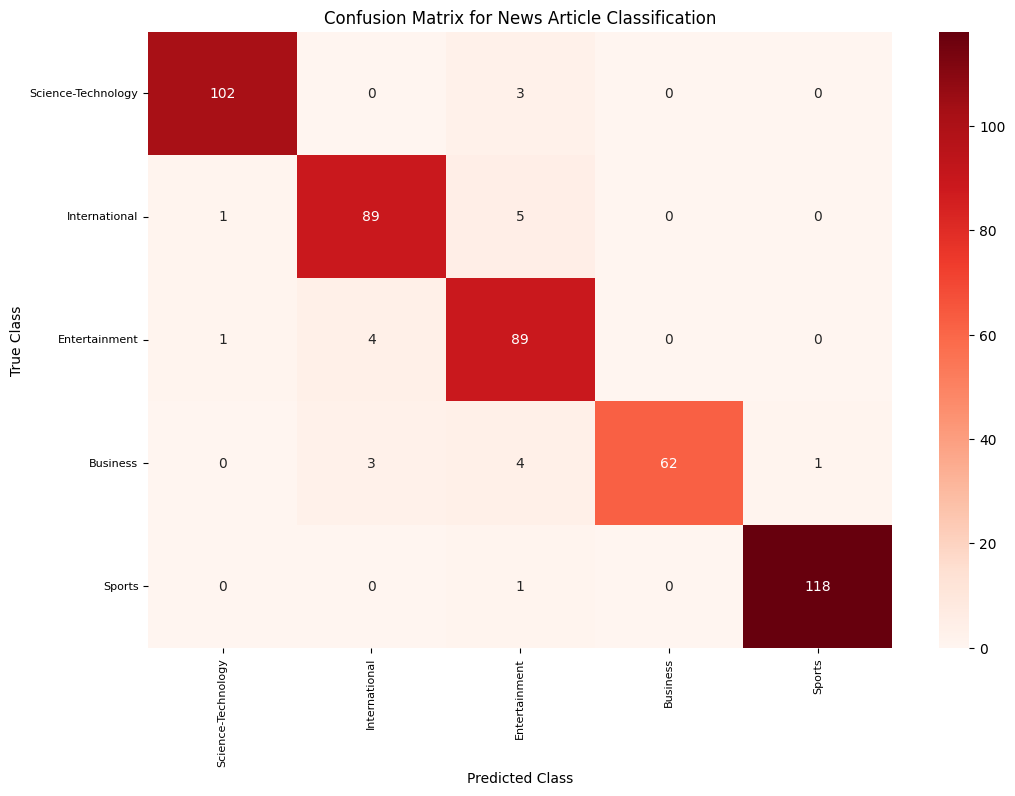


Classification Report: 
                    precision    recall  f1-score   support

          Business       0.98      0.97      0.98       105
     Entertainment       0.93      0.94      0.93        95
     International       0.87      0.95      0.91        94
Science-Technology       1.00      0.89      0.94        70
            Sports       0.99      0.99      0.99       119

          accuracy                           0.95       483
         macro avg       0.95      0.95      0.95       483
      weighted avg       0.95      0.95      0.95       483



In [140]:
naive_bayes_classifier = NBClassifier()
naive_bayes_classifier.train(X_train, y_train)

preds_nb = naive_bayes_classifier.predict(X_test)

df = pd.DataFrame()
df["preds"] = preds_nb
df["true"] = y_test
# print(df)
# print(preds_nb)
# print(y_test)

accuracy_nb = accuracy_score(y_test, preds_nb)
f1_nb = f1_score(y_test, preds_nb, average = "weighted")
conf_matrix_nb = confusion_matrix(y_test, preds_nb)

print(f"Accuracy: {(accuracy_nb*100):.2f}%")
print(f"F1 Score: {(f1_nb*100):.2f}%")
print("Confusion Matrix:")

plt.figure(figsize = (12, 8))
sns.heatmap(conf_matrix_nb, annot = True, fmt = "d", cmap = "Reds", xticklabels = naive_bayes_classifier.classes, yticklabels = naive_bayes_classifier.classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(fontsize = 8, rotation = 90)
plt.yticks(fontsize = 8, rotation = 0)
plt.title("Confusion Matrix for News Article Classification")
plt.show()
print(f"\nClassification Report: ")
print(classification_report(y_test, preds_nb))

**Evaluating with SKLearn's NaiveBayes.**

In [141]:
from sklearn.naive_bayes import MultinomialNB

SKLearn's NaiveBayes requires a vectorised approach, while our scratch implementation avoided the use of vectors with a custom counting approach.

Our approach can be refined to use vectors as input, there should not be any difference in the results.

In [142]:
class BagOfWords:
    def __init__(self):
        self.vocab = None
        self.mapping = None
        self.vector = None
        
    def fit(self, input):
        self.vocab = {'dummy'}
        self.vocab.remove('dummy')
        # print(self.vocab)
        
        for i in input:
            frags = i.split()
            for frag in frags:
                self.vocab.add(frag)

        self.vocab = sorted(self.vocab)
            
        self.mapping = {}
        
        index = 0
        for word in self.vocab:
            self.mapping[word] = index
            index += 1
        
        # print(self.mapping)
        
    def vectorise(self, input):
        vectors = np.zeros((len(input), len(self.vocab)), dtype = int)
        for i, text in enumerate(input):
            for word in text.split():
                if word in self.mapping:
                    vectors[i, self.mapping[word]] += 1
                    
        return vectors
    
bagofwords = BagOfWords()
bagofwords.fit(X_train)

X_train_v = bagofwords.vectorise(X_train)
X_test_v = bagofwords.vectorise(X_test)

**Results on Testing Data for SKLearn Multinomial Naive Bayes Classifier.**

Accuracy: 95.24%
F1 Score: 95.27%
Confusion Matrix:


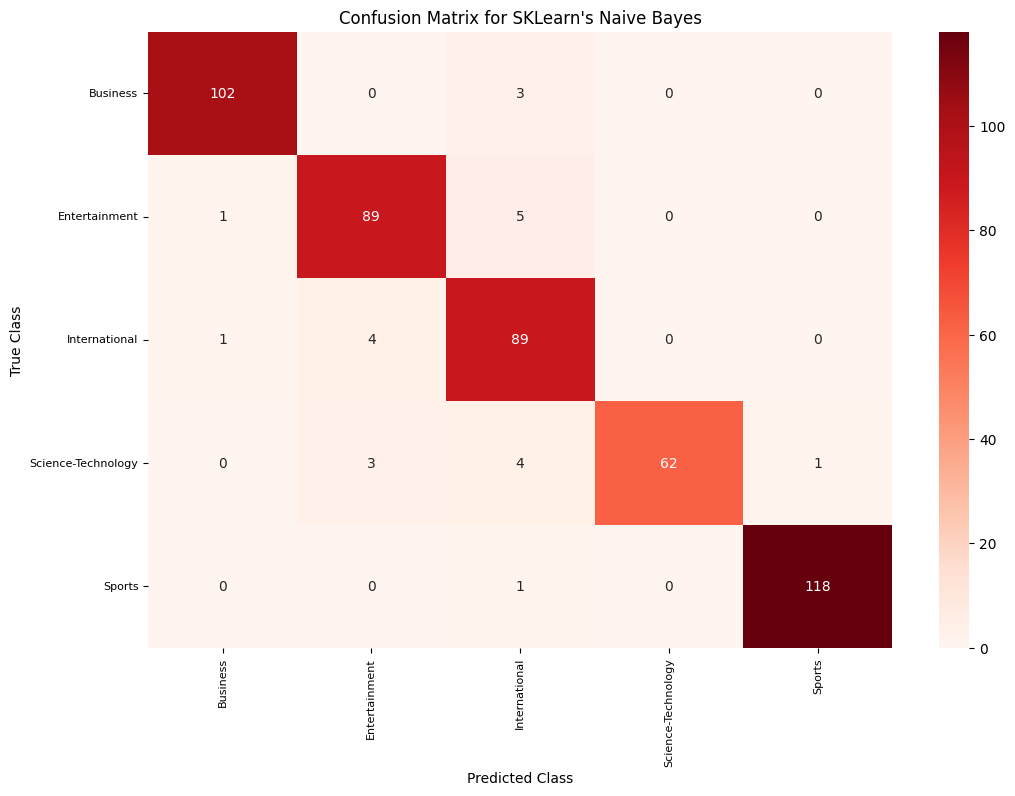


Classification Report: 
                    precision    recall  f1-score   support

          Business       0.98      0.97      0.98       105
     Entertainment       0.93      0.94      0.93        95
     International       0.87      0.95      0.91        94
Science-Technology       1.00      0.89      0.94        70
            Sports       0.99      0.99      0.99       119

          accuracy                           0.95       483
         macro avg       0.95      0.95      0.95       483
      weighted avg       0.95      0.95      0.95       483



In [143]:
from sklearn.naive_bayes import MultinomialNB

skmb = MultinomialNB()
skmb.fit(X_train_v, y_train)

preds_skmb = skmb.predict(X_test_v)

# df = pd.DataFrame()
# df["preds"] = predictions
# df["true"] = y_test

accuracy_skmb = accuracy_score(y_test, preds_skmb)
f1_skmb = f1_score(y_test, preds_skmb, average = "weighted")
conf_matrix_skmb = confusion_matrix(y_test, preds_skmb)

print(f"Accuracy: {(accuracy_skmb * 100):.2f}%")
print(f"F1 Score: {(f1_skmb * 100):.2f}%")
print("Confusion Matrix:")

plt.figure(figsize = (12, 8))
sns.heatmap(conf_matrix_skmb, annot = True, fmt = "d", cmap = "Reds", xticklabels = skmb.classes_, yticklabels = skmb.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(fontsize = 8, rotation = 90)
plt.yticks(fontsize = 8, rotation = 0)
plt.title("Confusion Matrix for SKLearn's Naive Bayes")
plt.show()

print("\nClassification Report: ")
print(classification_report(y_test, preds_skmb))

**Results are an exact match.**